# Sentiment Analysis Using Various Approaches

## Lexicon-based approach 
- Unsupervised learning
- Based on calculating sentiment scores of words in a document from lexicons.
- Each word's sentiment is determined, and the scores are combined to calculate the overall sentiment of the sentence. 
- A lexicon is a dictionary that contains a collection of words that is categorized as positive, negative, and neutral by experts. Their scores can change over time.
- Only those words listed in the lexicon will actually be scored.
- Disadvantages: words that are not in the lexicon will not be scored; some lexicons might be better suited for a specific use; it overlooks negation (lexicons only match words and not phrases, ie "not bad" is scored more negative instead of neutral)

In [72]:
import numpy as np 
import pandas as pd
import json
import time
import re
import seaborn as sns

# Text cleaning
from nltk import sent_tokenize, word_tokenize, regexp_tokenize
from nltk.stem import WordNetLemmatizer
import spacy 
nlp = spacy.load('en_core_web_sm')

# NLTK Bing Liu Lexicon 
import nltk
# nltk.download('opinion_lexicon')
from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize 

# VADER 
import nltk
# nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, confusion_matrix

# Supervised learning 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.calibration import CalibrationDisplay
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline 
from sklearn.svm import LinearSVC

from scipy.sparse import csr_matrix
from scipy.sparse import hstack, vstack

# Text Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt

# Topic Modeling 
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation

## Loading a subset of reviews and meta data

In [2]:
n = 1 
total_rows = 0

def process_chunks(file, chunksize = 1000):

    # Setting as global variables
    global n, total_rows  
    
    chunks = pd.read_json(file, lines=True, chunksize = chunksize)
    dfs = []  
    n_chunks = 0

    for chunk in chunks:
        dfs.append(chunk)
        n_chunks += 1  # Count the number of chunks processed
        print(len(chunk), " rows added")
        n += 1 
        total_rows += len(chunk)
        if n_chunks >= 10:  # Process only the first 5 chunks
            break  
            
    print("Done")
    print("Total rows:", total_rows)
    return pd.concat(dfs, ignore_index=True)

In [3]:
reviews = "../data/Home_and_Kitchen.jsonl"
meta = "../data/meta_Home_and_Kitchen.jsonl"

start = time.process_time()

reviews_subset = process_chunks(reviews)

end = time.process_time()
elapsed_time = end - start
print('Created a subset of the reviews dataset')
print('Execution time:', elapsed_time, 'seconds')

print('--------------')
start = time.process_time()

meta_subset = process_chunks(meta)

end = time.process_time()
elapsed_time = end - start
print('Created a subset of the meta dataset')
print('Execution time:', elapsed_time, 'seconds')

1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
Done
Total rows: 10000
Created a subset of the reviews dataset
Execution time: 0.390625 seconds
--------------
1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
Done
Total rows: 20000
Created a subset of the meta dataset
Execution time: 1.015625 seconds


## EDA

In [4]:
reviews_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   rating             10000 non-null  int64         
 1   title              10000 non-null  object        
 2   text               10000 non-null  object        
 3   images             10000 non-null  object        
 4   asin               10000 non-null  object        
 5   parent_asin        10000 non-null  object        
 6   user_id            10000 non-null  object        
 7   timestamp          10000 non-null  datetime64[ns]
 8   helpful_vote       10000 non-null  int64         
 9   verified_purchase  10000 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(2), object(6)
memory usage: 713.0+ KB


In [5]:
reviews_subset['rating'].value_counts()

rating
5    6821
4    1772
3     641
1     512
2     254
Name: count, dtype: int64

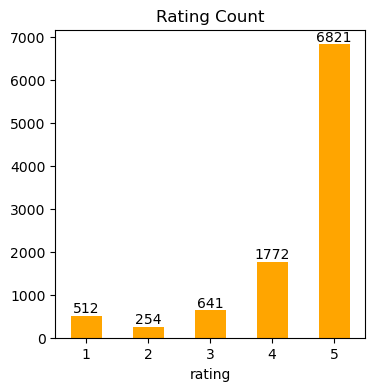

In [6]:
## Displays graphs directly within the notebook
%matplotlib inline 

ratings_count = reviews_subset.groupby('rating').size()

ax = ratings_count.plot(kind = 'bar', figsize = (4,4), color = 'orange')

ax.tick_params(axis='x', rotation=0)

# Add labels above the bars
for i in ax.containers:
    ax.bar_label(i)
    
ax.set_title('Rating Count');

### How many reviews are there per year?

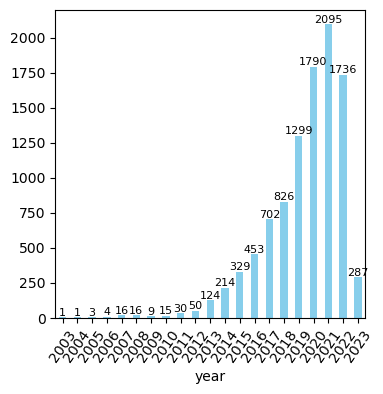

In [7]:
cleaned_text = reviews_subset.copy()

# Create a year column from the timestamp column 
cleaned_text['year'] = cleaned_text['timestamp'].dt.year

reviews_per_year = cleaned_text.groupby('year').size()
ax = reviews_per_year.plot(kind = 'bar', figsize = (4,4), color = 'skyblue')
ax.tick_params(axis='x', rotation=55)
for i in ax.containers:
    ax.bar_label(i, fontsize=8);


## Feature Engineering 

Create new features: word count, average word length, exclamation mark count, and sentiment.

In [8]:
# Word count
def word_count(text):
    words = text.split()
    return len(words)

# Average word length 
def avg_word_length(text):
    
    # Check for empty or white-space only string 
    if not text.strip():
        return 0
        
    words = text.split()
    if not words:  # Check if words list is empty
        return 0
        
    word_lengths = [len(word) for word in words]
    avg_word_length = sum(word_lengths)/len(words)
    
    return(avg_word_length) 

# Exclamation mark count 
def exclamation_count(text):
    doc = nlp(text)
    exclamations = []
    for token in doc: 
        if token.text == '!':
            exclamations.append(token.text)
    return len(exclamations)

In [9]:
cleaned_text['word_count'] = cleaned_text['text'].apply(word_count)
cleaned_text['avg_word_length'] = cleaned_text['text'].apply(avg_word_length)
cleaned_text['exclamation_count'] = cleaned_text['text'].apply(exclamation_count)

In [10]:
cleaned_text[['text', 'word_count', 'avg_word_length', 'exclamation_count']].head(3)

,text,word_count,avg_word_length,exclamation_count
0,Livid. Once again received an obviously used ...,28,4.678571,2
1,I purchased these for multiple reasons. The ma...,546,3.937729,0
2,[[VIDEOID:c87e962bc893a948856b0f1b285ce6cc]] I...,319,4.047022,0


In [11]:
cleaned_text['word_count'].describe()

count    10000.000000
mean        52.426600
std         60.472371
min          0.000000
25%         13.000000
50%         33.000000
75%         70.000000
max        708.000000
Name: word_count, dtype: float64

C:\Users\MJ\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


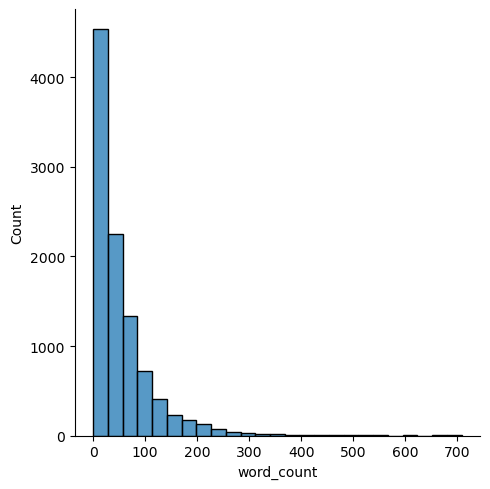

In [12]:
sns.displot(cleaned_text['word_count'],bins=25);

C:\Users\MJ\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


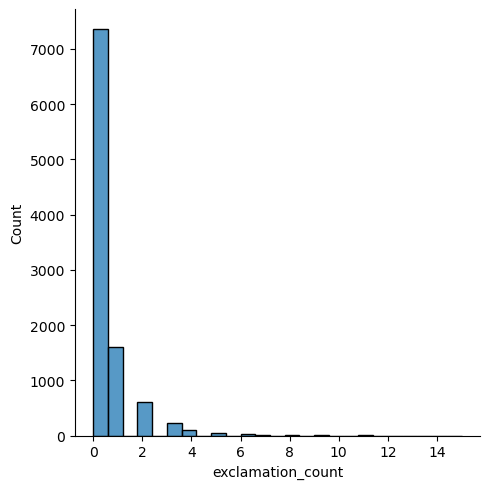

In [13]:
sns.displot(cleaned_text['exclamation_count'],bins=25);

## Text Cleaning - spaCy

In [14]:
stop_words = spacy.lang.en.stop_words.STOP_WORDS
print('Original stopwords count:', len(stop_words))

# Updating my stopwords list 
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Include/ exclude certain words
include_stopwords = {'would', 'I'}
exclude_stopwords = {'i', 'well', 'off', 'very', 'not', 'few', 'much'}

stop_words |= include_stopwords
stop_words -= exclude_stopwords

# Remove adjectives from my stopwords using spaCy
exclude_adjectives = {word for word in stop_words if nlp(word)[0].pos_ == "ADJ"}
print(exclude_adjectives)

stop_words -= exclude_adjectives
print('Stopwords count:', len(stop_words))

Original stopwords count: 326
{'latter', 'due', 'last', 'same', 'serious', 'former', 'top', 'least', 'many', 'various', 'empty', 'full', 'own', 'whole', 'several', 'other', 'such', 'third', 'whereafter'}
Stopwords count: 301


In [15]:
def clean_data(doc):
    doc = doc.lower()
    doc = nlp(doc)
    # Lemmatize words 
    lemmas = [token.lemma_ for token in doc]
    # Removing non-alphabetic characters and stopwords
    tokens = [lemma for lemma in lemmas if lemma.isalpha() and lemma not in stop_words]
    cleaned_doc = " ".join(tokens)
    
    return cleaned_doc

cleaned_text['spacy_text'] = cleaned_text['text'].apply(clean_data)

In [16]:
i = 0
print(f'Title: {cleaned_text.loc[i,"title"]}\n')

print(f'Text: {cleaned_text.loc[i,"text"]}\n')

print(f'Text: {cleaned_text.loc[i,"spacy_text"]}\n')

Title: Received Used & scratched item! Purchased new!

Text: Livid.  Once again received an obviously used item that has food on it & scratches. I purchased this new!!  Pics not loading rn. Will add them later. Disgusted.

Text: livid receive obviously use item food scratch purchase new pic not load rn add later disgust



## Bing Liu Lexicon

The Bing Liu lexicon has a total of 6, 786 words with 2,005 classified as positive and 4,781 as negative. CLassification is binary (positive or negative).

In [17]:
print('Total number of words in opinion lexicon', len(opinion_lexicon.words()))
print('Examples of positive words:', opinion_lexicon.positive()[:10])
print('Examples of negative words:', opinion_lexicon.negative()[:10])

Total number of words in opinion lexicon 6789
Examples of positive words: ['a+', 'abound', 'abounds', 'abundance', 'abundant', 'accessable', 'accessible', 'acclaim', 'acclaimed', 'acclamation']
Examples of negative words: ['2-faced', '2-faces', 'abnormal', 'abolish', 'abominable', 'abominably', 'abominate', 'abomination', 'abort', 'aborted']


In [18]:
pos_score = 1
neg_score = -1
word_dict = {}

# Adding the positive words to the dictionary
for word in opinion_lexicon.positive():
    word_dict[word] = pos_score 

# Adding the negative words to the dictionary 
for word in opinion_lexicon.negative():
    word_dict[word] = neg_score 

def bing_liu_score(text):
    sentiment_score = 0 
    bag_of_words = word_tokenize(text.lower())

    # Check if bag_of_words is empty
    if bag_of_words: 
        for word in bag_of_words: 
            if word in word_dict: 
                sentiment_score += word_dict[word]
        return sentiment_score / len(bag_of_words)
    else: 
        return 0

In [19]:
cleaned_text['Bing_Liu_score'] = cleaned_text['text'].apply(bing_liu_score)
cleaned_text['Bing_Liu_spaCy'] = cleaned_text['spacy_text'].apply(bing_liu_score)

## VADER Lexicon
Rule-based lexicon. 
9,000 features with scales of [-4] Extremely Negative to [4] Extremely Positive with [0] for Neutral or Neither. 

In [20]:
model = SentimentIntensityAnalyzer()

In [21]:
def vader_score(text):
    score = model.polarity_scores(text)
    compound_score = score['compound']
    return compound_score

In [22]:
cleaned_text['Vader_score'] = cleaned_text['text'].apply(vader_score)
cleaned_text['Vader_spaCy'] = cleaned_text['spacy_text'].apply(vader_score)

## Lexicon Sentiment Accuracy Scores 

In [23]:
cleaned_text[['Bing_Liu_score', 'Bing_Liu_spaCy', 'Vader_score', 'Vader_spaCy']].sample(3)

,Bing_Liu_score,Bing_Liu_spaCy,Vader_score,Vader_spaCy
450,0.142857,0.2,0.6249,0.6249
5793,0.037037,0.1,0.8468,0.8445
4312,0.285714,0.5,0.8957,0.8957


In [24]:
# Calculate mean sentiment score for each rating category
mean_scores = cleaned_text.groupby('rating').agg({
    'Bing_Liu_score':'mean',
    'Bing_Liu_spaCy': 'mean',
    'Vader_score': 'mean',
    'Vader_spaCy': 'mean'
}).reset_index()

print(mean_scores)

   rating  Bing_Liu_score  Bing_Liu_spaCy  Vader_score  Vader_spaCy
0       1       -0.031370       -0.063742    -0.115005    -0.038082
1       2        0.003011        0.004356     0.100559     0.156293
2       3        0.031123        0.062282     0.350320     0.365816
3       4        0.066978        0.143764     0.663724     0.645764
4       5        0.129455        0.249447     0.720333     0.710219


## Supervised Learning Approach ##

Using supervised learning models, we will classify the sentiment of a review based on pre-processed text from spaCy. Reviews will be classified as positive or negative sentiment based on their ratings:
- Positive (1): records with ratings of 4 and 5.
- Negative (0): records with ratings of 1 and 2.
- Neutral: records with ratings of 3 are removed.

### Feature Engineering: Sentiment Classification
Create a new column in our dataset to classify records based on our ratings. 

In [25]:
cleaned_text['sentiment'] = 0

# Classify records with rating higher than a 3, positive (1)
cleaned_text.loc[cleaned_text['rating'] > 3, 'sentiment'] = 1

# Classify records with rating lower than a 3, negative (0)
cleaned_text.loc[cleaned_text['rating'] < 3, 'sentiment'] = 0

# Remove records with a rating of 3
cleaned_text = cleaned_text.loc[cleaned_text['rating'] != 3].reset_index(drop=True)

In [26]:
# Remove observations that are empty after the cleaning step
cleaned_text = cleaned_text[cleaned_text['spacy_text'].str.len() != 0]
print('Record count:', len(cleaned_text))

Record count: 9351


### Text Vectorization with TF-IDF
Use TF-IDF vectorizer to transform the text into vectors based on the frequency of words in the text:

In [30]:
tfidf = TfidfVectorizer()
clf = MultinomialNB()

pipe = Pipeline([("tfidf", tfidf), ("clf", clf)])

param_grid = {
    'tfidf__ngram_range':[(1,1), (1,2), (1,3)],
    'tfidf__min_df':[1, 2, 5, 10, 20],
    'clf__fit_prior':[False, True]
}

### Model raining and Evaluation
The following models will be used in our analysis:
- Logistic Regression: a linear model for binary classification.
- Linear Support Vector Classification (SVC): A classifier that constructs a hyperplane to separate classes.
- Randomized Search Cross-Validation: A technique to tune hyperparameters for improving model performance.

#### Randomized Search Cross Validation

In [31]:
rs = RandomizedSearchCV(estimator = pipe, param_distributions = param_grid, verbose = 2, n_jobs = -1)
rs.fit(X_train['spacy_text'], y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('clf', MultinomialNB())]),
                   n_jobs=-1,
                   param_distributions={'clf__fit_prior': [False, True],
                                        'tfidf__min_df': [1, 2, 5, 10, 20],
                                        'tfidf__ngram_range': [(1, 1), (1, 2),
                                                               (1, 3)]},
                   verbose=2)

In [32]:
y_pred = rs.predict(X_test['spacy_text'])

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'ROC-AUC Score: {roc_auc_score(y_test, y_pred)}')
print(f'Classification Report: \n {classification_report(y_test,y_pred, zero_division = 0.0)}')
print(f'Confusion Matrix: \n {confusion_matrix(y_test, y_pred)}')

Accuracy: 0.9406734366648851
ROC-AUC Score: 0.7354938482960123
Classification Report: 
               precision    recall  f1-score   support

           0       0.69      0.49      0.57       153
           1       0.96      0.98      0.97      1718

    accuracy                           0.94      1871
   macro avg       0.83      0.74      0.77      1871
weighted avg       0.93      0.94      0.94      1871

Confusion Matrix: 
 [[  75   78]
 [  33 1685]]


In [33]:
# Finding the best parameters 
print(rs.best_params_)
print(rs.best_score_)

{'tfidf__ngram_range': (1, 2), 'tfidf__min_df': 5, 'clf__fit_prior': False}
0.9411764705882353


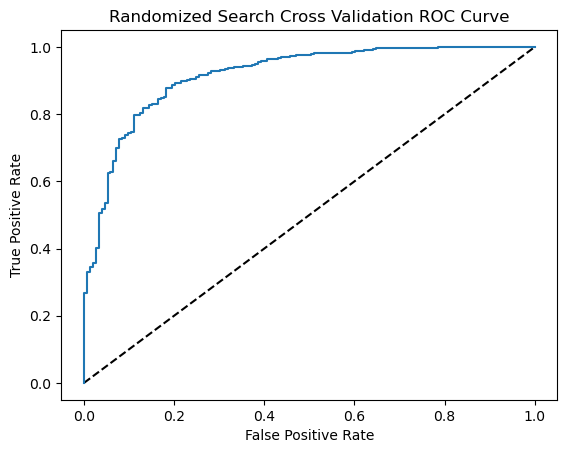

0.9161701933392682


In [34]:
sentiment_prob = rs.predict_proba(X_test['spacy_text'])
positive_class_prob = sentiment_prob[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, positive_class_prob, pos_label=1)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Randomized Search Cross Validation ROC Curve')
plt.show()

print(roc_auc_score(y_test, positive_class_prob))

#### Linear Support Vector Classification (SVC)

In [98]:
tfidf = TfidfVectorizer(min_df = 5, ngram_range = (1,3))

X_train_tf = tfidf.fit_transform(X_train['spacy_text'])
X_test_tf = tfidf.transform(X_test['spacy_text'])

linear = LinearSVC(random_state = 42, tol = 1e-5, max_iter = 10000)
linear.fit(X_train_tf, y_train)

LinearSVC(max_iter=10000, random_state=42, tol=1e-05)

In [45]:
y_pred = linear.predict(X_test_tf)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'ROC-AUC Score: {roc_auc_score(y_test, y_pred)}')
print(f'Classification Report: \n {classification_report(y_test,y_pred, zero_division = 0.0)}')
print(f'Confusion Matrix: \n {confusion_matrix(y_test, y_pred)}')

Accuracy: 0.9540352752538749
ROC-AUC Score: 0.7457466882756207
Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.50      0.64       153
           1       0.96      0.99      0.98      1718

    accuracy                           0.95      1871
   macro avg       0.93      0.75      0.81      1871
weighted avg       0.95      0.95      0.95      1871

Confusion Matrix: 
 [[  76   77]
 [   9 1709]]


### Logistic Regression

In [58]:
tfidf_log = TfidfVectorizer(min_df = 10, ngram_range = (1,3))

X_train_tf = tfidf_log.fit_transform(X_train['spacy_text'])
X_test_tf = tfidf_log.transform(X_test['spacy_text'])

logreg = LogisticRegression(max_iter = 1000).fit(X_train_tf, y_train)

In [59]:
y_pred = logreg.predict(X_test_tf)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'ROC-AUC Score: {roc_auc_score(y_test, y_pred)}')
print(f'Classification Report: \n {classification_report(y_test,y_pred, zero_division = 0.0)}')
print(f'Confusion Matrix: \n {confusion_matrix(y_test, y_pred)}')

Accuracy: 0.9374665954035275
ROC-AUC Score: 0.6265778721267319
Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.25      0.40       153
           1       0.94      1.00      0.97      1718

    accuracy                           0.94      1871
   macro avg       0.93      0.63      0.68      1871
weighted avg       0.94      0.94      0.92      1871

Confusion Matrix: 
 [[  39  114]
 [   3 1715]]


In [63]:
features = None
features = tfidf_log.get_feature_names_out(features)

sentiment = 0
idx = list(logreg.classes_).index(sentiment)


# # Extract coefficients from the Logistic Regression model 
intercept = logreg.intercept_[idx]
coefficients = logreg.coef_[idx]

coefficients_df = pd.DataFrame({
    'variable': ['intercept'] + list(features),
    'coefficient': [intercept] + list(coefficients)
})

coefficients_df.sort_values(by = 'coefficient', ascending = False)


,variable,coefficient
1369,love,4.453039
957,great,3.958642
1540,nice,3.886642
653,easy,3.403961
1820,perfect,3.228035
...,...,...
2928,waste,-2.948213
305,cheap,-2.989884
585,disappointed,-3.408069
2132,return,-4.378082


### Train-Test Split with Other Features

In [27]:
cleaned_text.columns

Index(['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase', 'year', 'word_count',
       'avg_word_length', 'exclamation_count', 'spacy_text', 'Bing_Liu_score',
       'Bing_Liu_spaCy', 'Vader_score', 'Vader_spaCy', 'sentiment'],
      dtype='object')

In [28]:
variables = ['rating', 'helpful_vote', 'verified_purchase', 'word_count', 'avg_word_length', 
            'exclamation_count', 'spacy_text', 'Bing_Liu_score', 'Bing_Liu_spaCy', 'Vader_score', 'Vader_spaCy']
X = cleaned_text[variables]
y = cleaned_text['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42, stratify = y)

In [29]:
print ('Size of Training Data ', X_train.shape[0])
print ('Size of Test Data ', X_test.shape[0])
print ('Distribution of classes in Training Data :')
print ('Positive Sentiment ', str(sum(y_train == 1)/ len(y_train) * 100.0))
print ('Negative Sentiment ', str(sum(y_train == 0)/ len(y_train) * 100.0))
print ('Distribution of classes in Testing Data :')
print ('Positive Sentiment ', str(sum(y_test == 1)/ len(y_test) * 100.0))
print ('Negative Sentiment ', str(sum(y_test == 0)/ len(y_test) * 100.0))


Size of Training Data  7480
Size of Test Data  1871
Distribution of classes in Training Data :
Positive Sentiment  91.81818181818183
Negative Sentiment  8.181818181818182
Distribution of classes in Testing Data :
Positive Sentiment  91.82255478353821
Negative Sentiment  8.177445216461784


### Model Testing

In [93]:
variables = ['helpful_vote', 'verified_purchase', 'word_count', 'avg_word_length', 
            'exclamation_count', 'Bing_Liu_score', 'Bing_Liu_spaCy', 'Vader_score', 'Vader_spaCy']
X_train[variables].astype(float)

,helpful_vote,verified_purchase,word_count,avg_word_length,exclamation_count,Bing_Liu_score,Bing_Liu_spaCy,Vader_score,Vader_spaCy
5851,0.0,0.0,73.0,4.849315,0.0,0.120482,0.243243,0.8555,0.8750
1409,4.0,1.0,40.0,4.100000,0.0,-0.022222,-0.153846,-0.6705,-0.7009
600,0.0,1.0,12.0,4.916667,0.0,0.375000,0.750000,0.8612,0.8612
5047,0.0,1.0,14.0,6.071429,0.0,0.000000,0.000000,0.2960,0.2960
7201,0.0,1.0,10.0,3.700000,0.0,0.166667,0.333333,0.2944,0.3520
...,...,...,...,...,...,...,...,...,...
1017,1.0,1.0,42.0,4.404762,0.0,0.021277,0.055556,0.6369,0.7269
6616,0.0,1.0,6.0,4.833333,0.0,-0.166667,-0.200000,0.4215,0.4215
208,0.0,1.0,39.0,4.435897,3.0,0.043478,0.150000,0.5033,0.7579
4907,0.0,0.0,31.0,4.612903,1.0,0.147059,0.266667,0.8353,0.9099


In [94]:
m = csr_matrix(X_train[variables].astype(float))
n = csr_matrix(X_test[variables].astype(float))

X_train_stack = hstack((m, X_train_tf))
X_test_stack = hstack((n, X_test_tf))

In [99]:
linear.fit(X_train_stack, y_train)

y_pred = linear.predict(X_test_stack)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'ROC-AUC Score: {roc_auc_score(y_test, y_pred)}')
print(f'Classification Report: \n {classification_report(y_test,y_pred, zero_division = 0.0)}')
print(f'Confusion Matrix: \n {confusion_matrix(y_test, y_pred)}')

Accuracy: 0.9492250133618386
ROC-AUC Score: 0.7609889900857509
Classification Report: 
               precision    recall  f1-score   support

           0       0.77      0.54      0.63       153
           1       0.96      0.99      0.97      1718

    accuracy                           0.95      1871
   macro avg       0.87      0.76      0.80      1871
weighted avg       0.94      0.95      0.94      1871

Confusion Matrix: 
 [[  82   71]
 [  24 1694]]


C:\Users\MJ\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Sample Application

In [46]:
sample_reviews = cleaned_text.sample(5)
sample_reviews_tf = tfidf.transform(sample_reviews['spacy_text'])
sentiment_predictions = linear.predict(sample_reviews_tf)
sentiment_predictions = pd.DataFrame(data = sentiment_predictions,
                                     index=sample_reviews.index,
                                     columns=['sentiment_prediction'])
sample_reviews = pd.concat([sample_reviews, sentiment_predictions], axis=1)
print ('Some sample reviews with their sentiment - ')
sample_reviews[['text', 'spacy_text','rating', 'sentiment_prediction']]


Some sample reviews with their sentiment - 


,text,spacy_text,rating,sentiment_prediction
3745,Perfect for what we needed. Used for mothers w...,perfect need use mother wake granddaughter han...,5,1
2989,I wished some one had a blender invented like ...,wish blender invent like love motor top fit ea...,5,1
7655,This is exactly as pictured and the colors are...,exactly picture color perfect need nice weight...,5,1
4338,I love these brushes. I used one for cleaning ...,love brush use clean scrub pan stuck food bris...,5,1
8607,Such a great set and so good quality. Don’t he...,such great set good quality not hesitate buy,5,1


## Topic Modeling

Unsupervised learning NLP technique to find the underlying topics in a collection of text documents. 

Singular Value Decomposition (SVD, aka Latent Semantic Indexing)

Non-Negative Matrix Factorization (NMF) yields two matrices: W and H. Matrix W (document-topic matrix) shows the distribution of the topics across the documents. Matrix H (term-topic matrix) captures the term significance across the topics. 
- Easier to interpret since elements in matrices is positive
- Higher score means stronger relevance 

In [47]:
# Function that displays the top 10 words in the topics
def display_topics(model, features, no_top_words = 5):
    for topic, word_vector in enumerate(model.components_):
        total = word_vector.sum()
        largest = word_vector.argsort()[::-1] # invert sort order 
        print(f"\nTopic {topic:02d}") ## Topic number 
        for i in range(0, no_top_words): 
            # print(f"    {features[largest[i]]} ({word_vector[largest[i]] * 100.0 / total:.2f})")
            print(" %s (%2.2f)" % (features[largest[i]], word_vector[largest[i]]*100.0/total))
    

### SVD (Singular Value Decomposition)

In [48]:
svd_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svd', TruncatedSVD(n_components = 7))
])

svd_pipe.fit(cleaned_text['spacy_text'])
vocab = svd_pipe.named_steps['tfidf'].get_feature_names_out()
components = svd_pipe.named_steps['svd'].components_

In [49]:
topic_num = 0

pd.DataFrame({
    'word': vocab,
    'weight': components[topic_num]
}).sort_values('weight', ascending = False).head(10)

,word,weight
5920,product,0.614103
3232,good,0.569168
3312,great,0.174050
5070,not,0.159076
8401,very,0.126264
4435,love,0.126012
5019,nice,0.106472
8570,well,0.105488
4406,look,0.104913
8318,use,0.104904


In [50]:
display_topics(svd_pipe.named_steps['svd'], vocab)


Topic 00
 product (4.77)
 good (4.43)
 great (1.35)
 not (1.24)
 very (0.98)

Topic 01
 product (-2.57)
 good (-1.75)
 wilton (-0.00)
 communication (-0.00)
 nespressos (-0.00)

Topic 02
 love (-12.53)
 great (-4.25)
 beautiful (-0.98)
 gift (-0.81)
 product (-0.79)

Topic 03
 great (-19.44)
 work (-5.67)
 price (-2.48)
 product (-2.02)
 look (-1.93)

Topic 04
 nice (-8.75)
 very (-5.98)
 quality (-4.50)
 look (-3.56)
 soft (-2.25)

Topic 05
 work (-18.47)
 very (-17.04)
 well (-9.04)
 easy (-8.63)
 clean (-4.99)

Topic 06
 perfect (-49.18)
 good (-27.43)
 work (-25.38)
 size (-14.13)
 need (-8.37)


### NMF (Non-negative Matrix Factorization)

In [54]:
nmf_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nmf', NMF(n_components = 7))
])

nmf_pipe.fit(cleaned_text['spacy_text'])

nmf_vocab = nmf_pipe.named_steps['tfidf'].get_feature_names_out()
nmf_components = nmf_pipe.named_steps['nmf'].components_

In [57]:
topic_num = 3

pd.DataFrame({
    'word': nmf_vocab,
    'weight': nmf_components[topic_num]
}).sort_values('weight', ascending = False).head(10)

,word,weight
3312,great,2.876835
5879,price,0.453079
4406,look,0.347120
6020,quality,0.241323
8348,value,0.164986
2359,easy,0.161073
5920,product,0.141674
957,buy,0.141211
6160,recommend,0.117265
3171,gift,0.097011


In [53]:
display_topics(nmf_pipe.named_steps['nmf'], vocab)


Topic 00
 product (42.79)
 good (36.51)
 quality (1.18)
 price (0.62)
 excellent (0.26)

Topic 01
 not (1.99)
 use (1.30)
 like (0.93)
 review (0.77)
 easy (0.74)

Topic 02
 love (26.60)
 beautiful (1.99)
 color (1.67)
 gift (1.65)
 buy (1.48)

Topic 03
 great (24.45)
 price (3.85)
 look (2.95)
 quality (2.05)
 value (1.40)

Topic 04
 nice (6.15)
 very (5.78)
 look (2.79)
 quality (2.65)
 soft (1.87)

Topic 05
 work (19.99)
 well (9.43)
 perfectly (1.63)
 need (1.23)
 expect (0.87)

Topic 06
 perfect (19.21)
 size (4.58)
 need (2.17)
 fit (1.96)
 gift (1.27)
